<h1>5장 텍스트 클러스터링과 토픽 모델링</h1>
<i>다양한 언어 모델을 사용해 문서를 클러스터링하기.</i>

<a href="https://github.com/rickiepark/handson-llm"><img src="https://img.shields.io/badge/GitHub%20Repository-black?logo=github"></a>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/rickiepark/handson-llm/blob/main/chapter05.ipynb)

---

이 노트북은 <[핸즈온 LLM](https://tensorflow.blog/handson-llm/)> 책 5장의 코드를 담고 있습니다.

---

<a href="https://tensorflow.blog/handson-llm/">
<img src="https://tensorflow.blog/wp-content/uploads/2025/05/ed95b8eca688ec98a8_llm.jpg" width="350"/></a>

### [선택사항] - <img src="https://colab.google/static/images/icons/colab.png" width=100>에서 패키지 선택하기


이 노트북을 구글 코랩에서 실행한다면 다음 코드 셀을 실행하여 이 노트북에서 필요한 패키지를  설치하세요.

---

💡 **NOTE**: 이 노트북의 코드를 실행하려면 GPU를 사용하는 것이 좋습니다. 구글 코랩에서는 **런타임 > 런타임 유형 변경 > 하드웨어 가속기 > T4 GPU**를 선택하세요.

---


사용 패키지 버전
* transformers 4.57.3
* datasets 4.0.0
* sentence-transformers 5.2.0
* umap-learn 0.5.9.post2
* hdbscan 0.8.41
* bertopic 0.17.4
* datamapplot 0.6.4
* openai 2.12.0

In [1]:
%%capture
!pip install bertopic datamapplot

In [2]:
# 깃허브에서 위젯 상태 오류를 피하기 위해 진행 표시줄을 나타내지 않도록 설정합니다.
from transformers.utils import logging

logging.disable_progress_bar()

# 아카이브 논문: 계산 및 언어

In [3]:
# 허깅 페이스에서 데이터를 로드합니다.
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]

# 데이터를 추출합니다.
abstracts = dataset["Abstracts"]
titles = dataset["Titles"]

Generating train split: 0 examples [00:00, ? examples/s]

# 텍스트 클러스터링을 위한 파이프라인

## 1. 문서 임베딩

In [4]:
from sentence_transformers import SentenceTransformer

# 각각의 초록에 대한 임베딩을 만듭니다.
embedding_model = SentenceTransformer('thenlper/gte-small')
embeddings = embedding_model.encode(list(abstracts), show_progress_bar=True)

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [5]:
# 만들어진 임베딩의 차원을 확인합니다.
embeddings.shape

(44949, 384)

## 2. 임베딩 차원 축소하기

In [6]:
from umap import UMAP

# 입력 임베딩을 384차원에서 5차원으로 줄입니다.
umap_model = UMAP(
    n_components=5, min_dist=0.0, metric='cosine', random_state=42, n_jobs=1
)
reduced_embeddings = umap_model.fit_transform(embeddings)

## 3. 축소된 임베딩 클러스터링

In [7]:
from hdbscan import HDBSCAN

# 모델을 훈련하고 클러스터를 추출합니다.
hdbscan_model = HDBSCAN(min_cluster_size=50).fit(reduced_embeddings)
clusters = hdbscan_model.labels_

# 클러스터 개수를 확인합니다.
len(set(clusters))

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


150

## 4. 클러스터 조사

클러스터 0에 있는 처음 세 개의 문서를 수동으로 조사합니다:

In [9]:
import numpy as np

# 클러스터 0에 있는 처음 세 개의 문서를 출력합니다
cluster = 0
for index in np.where(clusters==cluster)[0][:3]:
    print(list(abstracts)[index][:300] + "... \n")

  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf... 



그다음 시각화를 통해 생성된 클러스터를 이해하기 위해 임베딩을 2차원으로 줄입니다.

In [10]:
import pandas as pd

# 384차원의 임베딩을 2차원으로 줄입니다.
reduced_embeddings = UMAP(
    n_components=2, min_dist=0.0, metric='cosine', random_state=42, n_jobs=1
).fit_transform(embeddings)

# 데이터프레임을 만듭니다.
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["title"] = titles
df["cluster"] = [str(c) for c in clusters]

# 정상치(클러스터)와 이상치를 선택합니다.
clusters_df = df.loc[df.cluster != "-1", :]
outliers_df = df.loc[df.cluster == "-1", :]

### 정적 그래프

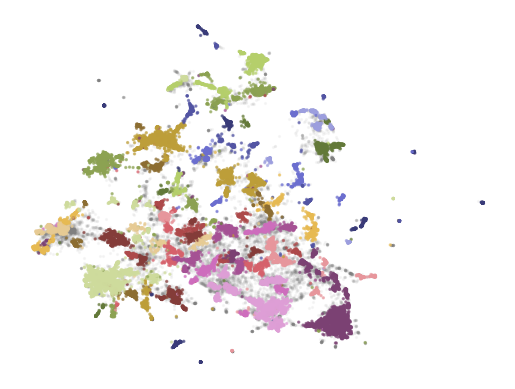

In [11]:
import matplotlib.pyplot as plt

# 이상치와 정상치를 그래프에 나타냅니다.
plt.scatter(outliers_df.x, outliers_df.y, alpha=0.05, s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y, c=clusters_df.cluster.astype(int),
    alpha=0.6, s=2, cmap='tab20b'
)
plt.axis('off')
plt.show()

# 텍스트 클러스터링에서 토픽 모델링으로

## BERTopic: 모듈화된 토픽 모델링 프레임워크

In [12]:
from bertopic import BERTopic

# 앞서 정의한 모델을 사용해 BERTopic 모델을 훈련합니다.
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstracts, embeddings)

2026-01-02 08:17:31,311 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-02 08:18:21,995 - BERTopic - Dimensionality - Completed ✓
2026-01-02 08:18:21,998 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-02 08:18:23,361 - BERTopic - Cluster - Completed ✓
2026-01-02 08:18:23,374 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-02 08:18:27,380 - BERTopic - Representation - Completed ✓


위 코드를 실행하여 얻은 토픽을 살펴 보죠.

In [13]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  13904                               -1_the_of_and_to   
1        0   2191                 0_question_qa_answer_questions   
2        1   2039                   1_speech_asr_recognition_end   
3        2   1517          2_medical_clinical_biomedical_patient   
4        3   1242  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
145    144     53           144_emoji_emojis_emoticons_sentiment   
146    145     53          145_sentence_embeddings_sts_embedding   
147    146     53           146_counseling_mental_therapy_health   
148    147     53         147_coherence_discourse_paragraph_text   
149    148     52            148_gans_gan_adversarial_generation   

                                        Representation  \
0    [the, of, and, to, in, we, language, that, for...   
1    [question, qa, answer, questions, answering, a...   
2    [speech, asr, recognition, end, acoustic, spea...   
3    [medical, clinical, biomedical, patient, healt...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
145  [emoji, emojis, emoticons, sentiment, social, ...   
146  [sentence, embeddings, sts, embedding, similar...   
147  [counseling, mental, therapy, health, psychoth...   
148  [coherence, discourse, paragraph, text, cohesi...   
149  [gans, gan, adversarial, generation, generativ...   

                                   Representative_Docs  
0    [  We consider the problem of learning general...  
1    [  A key challenge of multi-hop question answe...  
2    [  End-to-end Speech Translation (ST) models h...  
3    [  Biomedical language understanding benchmark...  
4    [  Recent advances in natural language process...  
..                                                 ...  
145  [  The frequent use of Emojis on social media ...  
146  [  Sentence representation at the semantic lev...  
147  [  Mental health care poses an increasingly se...  
148  [  While there has been significant progress t...  
149  [  Text generation is of particular interest i...  

[150 rows x 5 columns]

기본 모델을 사용해 수 백개의 토픽이 생성되었습니다. `get_topic()` 메서드를 사용해 토픽에 있는 상위 10개의 키워드와 c-TF-IDF 가중치를 얻을 수 있습니다.

In [14]:
topic_model.get_topic(0)

[('question', np.float64(0.02162058003446346)),
 ('qa', np.float64(0.016123785703670186)),
 ('answer', np.float64(0.016078230489519188)),
 ('questions', np.float64(0.016040829463486644)),
 ('answering', np.float64(0.015047088276370123)),
 ('answers', np.float64(0.009948407927565444)),
 ('retrieval', np.float64(0.00944023051937993)),
 ('comprehension', np.float64(0.007921847777973706)),
 ('reading', np.float64(0.007372432313408758)),
 ('the', np.float64(0.006389909102421698))]

`find_topics()` 함수를 사용하여 검색어를 기반으로 토픽을 찾을 수 있습니다. 토픽 모델링에 관한 토픽을 찾아 보죠:

In [15]:
topic_model.find_topics("topic modeling")

([21, -1, 2, 40, 37],
 [np.float32(0.95407367),
  np.float32(0.9106812),
  np.float32(0.90857077),
  np.float32(0.908509),
  np.float32(0.90454984)])

토픽 21가 검색어와 비교적 유사도가 높습니다(0.95). 이 토픽을 조사해 보면 실제 토픽 모델링에 관한 토픽임을 알 수 있습니다:

In [16]:
topic_model.get_topic(21)

[('topic', np.float64(0.06688093099994581)),
 ('topics', np.float64(0.0348470997426692)),
 ('lda', np.float64(0.016026471533786064)),
 ('latent', np.float64(0.01321780642115571)),
 ('document', np.float64(0.013016965788579117)),
 ('documents', np.float64(0.012890993296234781)),
 ('modeling', np.float64(0.012044529872189525)),
 ('dirichlet', np.float64(0.009571278238157984)),
 ('word', np.float64(0.008610325328886186)),
 ('allocation', np.float64(0.007483141632248138))]

부분적으로 고전적인 LDA 기법에 관한 토픽처럼 보입니다. BERTopic 논문이 토픽 21에 할당되어 있는지 확인해 보죠:

In [17]:
topic_model.topics_[titles.index('BERTopic: Neural topic modeling with a class-based TF-IDF procedure')]

21

맞군요! 이 제목에는 LDA와 관련이 적은 "modeling"와 "topic" 같은 단어가 포함되어 있기 때문에 그럴거라 기대했습니다.

### 시각화

**문서 시각화**

In [18]:
# 토픽과 문서를 시각화합니다.
fig = topic_model.visualize_documents(
    list(titles),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    hide_annotations=True
)

# 범례 폰트를 업데이트합니다.
fig.update_layout(font=dict(size=16))

In [19]:
# 키워드 순서대로 막대 그래프를 그립니다.
topic_model.visualize_barchart()

In [20]:
# 토픽 사이의 관계를 시각화합니다.
topic_model.visualize_heatmap(n_clusters=30)

In [21]:
# 토픽 사이의 잠재적 계층 구조를 시각화합니다.
topic_model.visualize_hierarchy()

## 표현 모델

다음 예제에서 모델을 훈련한 후에 토픽 표현을 업데이트하겠습니다. 이렇게 하면 빠르게 여러번 반복할 수 있습니다. 만약 훈련을 시작할 때 표현 모델을 사용하고 싶다면 다음과 같이 실행하세요:

```python
from bertopic.representation import KeyBERTInspired
from bertopic import BERTopic

# 표현 모델을 만듭니다.
representation_model = KeyBERTInspired()

# BERTopic의 기본 파이프라인 위에 표현 모델을 사용합니다.
topic_model = BERTopic(representation_model=representation_model)
```

표현 블록을 사용하기 전에 먼저 표현 모델을 사용할 때와 그렇지 않을 때를 비교하기 위해 원본 토픽 표현을 복사하겠습니다.

In [22]:
# 원본 표현을 복사합니다.
from copy import deepcopy
original_topics = deepcopy(topic_model.topic_representations_)

In [23]:
def topic_differences(model, original_topics, nr_topics=5):
    """두 모델의 토픽 표현 차이를 보여줍니다"""
    df = pd.DataFrame(columns=["Topic", "Original", "Updated"])
    for topic in range(nr_topics):

        # 모델과 토픽마다 상위 5개 단어를 추출합니다.
        og_words = " | ".join(list(zip(*original_topics[topic]))[0][:5])
        new_words = " | ".join(list(zip(*model.get_topic(topic)))[0][:5])
        df.loc[len(df)] = [topic, og_words, new_words]

    return df

### KeyBERTInspired

In [24]:
from bertopic.representation import KeyBERTInspired

# KeyBERTInspired를 사용해 토픽 표현을 업데이트합니다.
representation_model = KeyBERTInspired()
topic_model.update_topics(abstracts, representation_model=representation_model)

# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | bleu | neural   

                                             Updated  
0  retrieval | answering | comprehension | questi...  
1  translation | speech | language | phonetic | t...  
2       nlp | language | medicine | medical | corpus  
3  summarization | summarizing | summarisation | ...  
4  translation | translate | translations | trans...

### MMR(Maximal Marginal Relevance)

In [25]:
from bertopic.representation import MaximalMarginalRelevance

# MaximalMarginalRelevance를 사용해 토픽 표현을 업데이트합니다.
representation_model = MaximalMarginalRelevance(diversity=0.5)
topic_model.update_topics(abstracts, representation_model=representation_model)

# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)

Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | bleu | neural   

                                             Updated  
0  questions | retrieval | comprehension | to | k...  
1        speech | asr | model | training | automatic  
2  clinical | biomedical | patient | healthcare |...  
3  summarization | document | extractive | rouge ...  
4       translation | nmt | bleu | neural | parallel

## 텍스트 생성



### Flan-T5

In [26]:
from transformers import pipeline
from bertopic.representation import TextGeneration

prompt = """I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the documents and keywords, what is this topic about?"""

# Flan-T5를 사용해 토픽 표현을 업데이트합니다.
generator = pipeline('text2text-generation', model='google/flan-t5-small')
representation_model = TextGeneration(
    generator, prompt=prompt, doc_length=50, tokenizer="whitespace"
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)

Device set to use cuda:0
100%|██████████| 150/150 [00:48<00:00,  3.12it/s]


Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | bleu | neural   

                                 Updated  
0  Answer Sentence Selection |  |  |  |   
1     Speech-enabled systems |  |  |  |   
2               Science/Tech |  |  |  |   
3  Abstractive summarization |  |  |  |   
4               Science/Tech |  |  |  |

### 오픈AI

In [27]:
import openai
from bertopic.representation import OpenAI

prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short topic label in the following format:
topic: <short topic label>
"""

# GPT-3.5를 사용해 토픽 표현을 업데이트합니다.
client = openai.OpenAI(api_key="YOUR_KEY_HERE")
representation_model = OpenAI(
    client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt
)
topic_model.update_topics(abstracts, representation_model=representation_model)

# 토픽의 차이를 보여줍니다.
topic_differences(topic_model, original_topics)

100%|██████████| 150/150 [01:37<00:00,  1.55it/s]


Topic                                           Original  \
0      0     question | qa | answer | questions | answering   
1      1        speech | asr | recognition | end | acoustic   
2      2  medical | clinical | biomedical | patient | he...   
3      3  summarization | summaries | summary | abstract...   
4      4        translation | nmt | machine | bleu | neural   

                                             Updated  
0  Advanced Methods in Question Answering and Doc...  
1  Advances in Speech Recognition and Translation...  
2    Medical Language Models and Clinical AI Systems  
3     Advances in Abstractive Document Summarization  
4  Neural Machine Translation and Resource Manage...

Calculating medoids: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


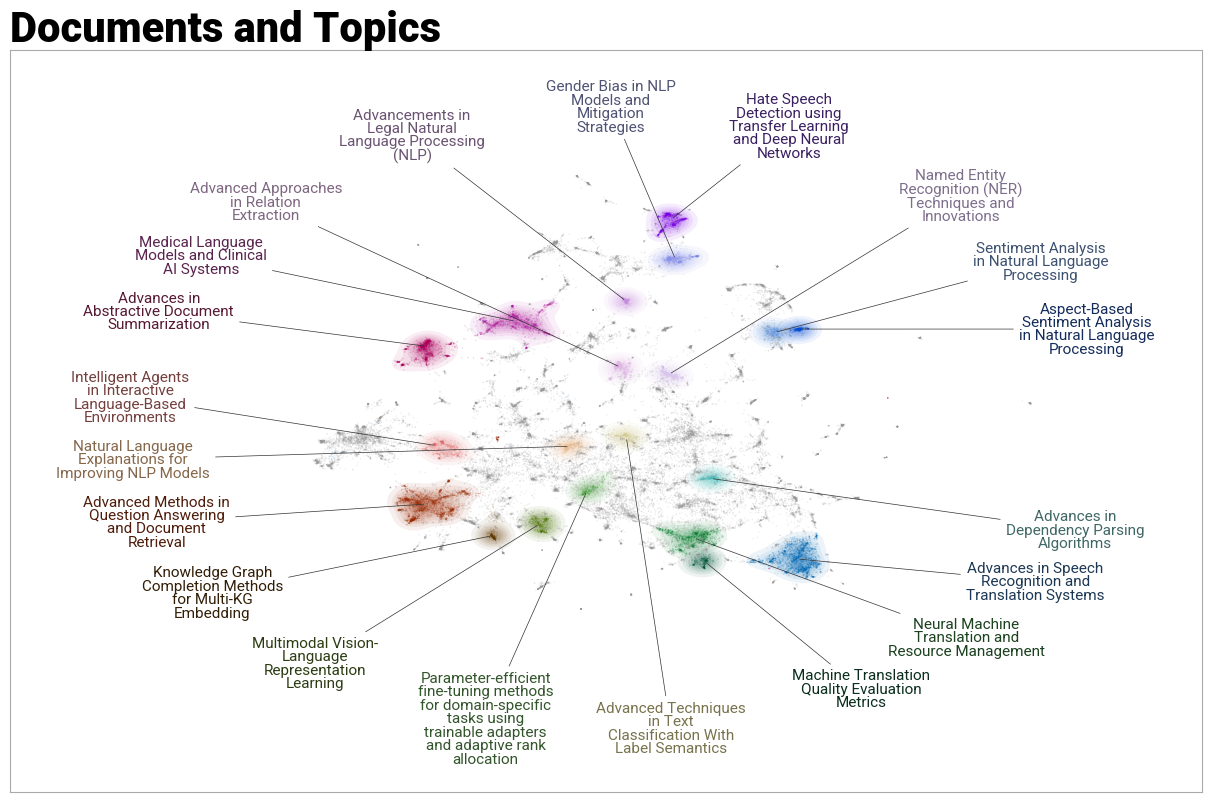

In [28]:
# 토픽과 문서를 시각화합니다.
fig = topic_model.visualize_document_datamap(
    titles,
    topics=list(range(20)),
    reduced_embeddings=reduced_embeddings,
    width=1200,
    datamap_kwds={
    'label_wrap_width': 20,
    'use_medoids': True,
    'label_font_size': 11
    }
)

## 보너스: 워드 클라우드(Word Cloud)


먼저, 흥미로운 워드 클라우드를 만들기 위해 각 토픽이 10개 이상의 단어로 표현되어야 합니다.

In [29]:
topic_model.update_topics(abstracts, top_n_words=500)

2026-01-02 08:22:54,032 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


그다음 다음 코드를 실행하여 'topic modeling' 토픽에 대한 워드 클라우드를 만듭니다:

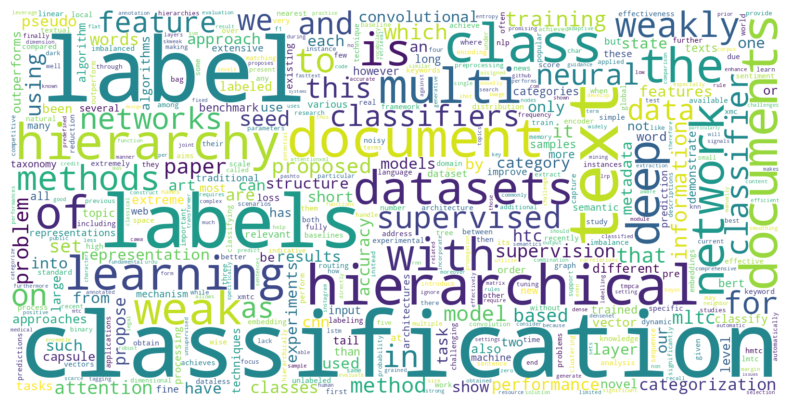

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    plt.figure(figsize=(10,5))
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000, width=1600, height=800)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# 워드 클라우드를 출력합니다.
create_wordcloud(topic_model, topic=17)